In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

In [14]:
# Sample Dataset

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)  # make_classification(): Generate a random n-class classification problem.
X = X.astype(np.float32)    # [[-2.0608628   2.6613927 ], ..., [-1.2685953  -1.6794535 ]]
Y = Y.astype(np.int32)      # [1 0 1 0, ..., 1 1 0 0]

# Split into train and test dataset
train_x, test_x = np.split(X, [n*8//10])    # train_x: [[ 0.94825596 -0.3122081 ], ..., [ 0.92149407  1.1544586 ]]
                                            # test_x: [[-0.00848508 -1.053148  ], ..., [ 1.1846237   0.8679223 ]]   (smaller)
train_labels, test_labels = np.split(Y, [n*8//10])  # train_labels: [0 0 1, ..., 1 0 1]
                                                    # test_labels: [0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0]   (smaller)


In [27]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')    # The text is formatted using LaTeX-style mathematical notation enclosed in dollar signs. 
                                                # x_i[0] indicates the first component of the variable x_i,
                                                # and (feature 1) is a description provided to indicate the meaning of the first component.
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)    # s: size of the markers   alpha: transparency (opacity) of the markers
    fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11912\4057281151.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


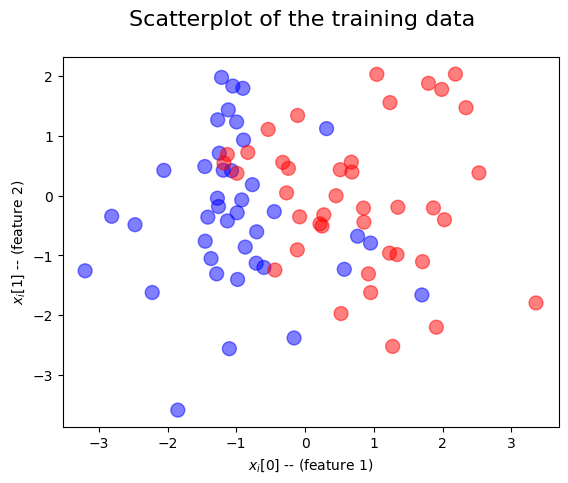

In [28]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)
plt.show()

In [25]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


In [ ]:
# Loss functions for regression

# helper function for plotting various loss functions
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1, len(functions), figsize=(9, 3))    # Create a figure and a set of subplots.
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()